In [113]:
from IPython import display
from matplotlib import pyplot as plt 
from mxnet import autograd, nd, gluon
import mxnet as mx
import random
from mxnet.gluon import nn

In [3]:
num_inputs = 2
num_examples = 1000
true_w = nd.array([2, -3.4])
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

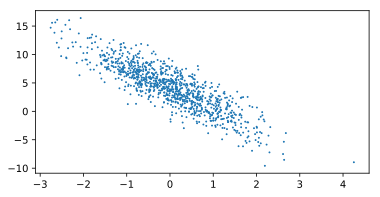

In [4]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=(6, 3))
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

In [40]:
def data_iter(batch_size, features, labels):
    random.seed(0)
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order 
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)

In [42]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[-2.045362   -0.44335487]
 [-0.38817322 -0.35244492]
 [ 2.845604   -0.5142364 ]
 [ 1.1838405   0.654279  ]
 [-2.0051894  -1.0490868 ]
 [-0.08951817  0.3183551 ]
 [-1.4932036   0.13177635]
 [-0.10685237  0.3870012 ]
 [ 1.9469851   0.04463983]
 [ 1.8681852   0.13305227]]
<NDArray 10x2 @cpu(0)> 
[ 1.6405038  4.608702  11.636032   4.3237557  3.7439334  2.9448102
  0.7656811  2.6694508  7.9360065  7.4904346]
<NDArray 10 @cpu(0)>


In [59]:
def initialize_parameters(n_x, n_y):
    mx.random.seed(0)
    W = nd.random.randn(n_y, n_x)
    b = nd.zeros(1)
    W.attach_grad()
    b.attach_grad()
    parameters = {'W': W, 'b': b}
    
    return parameters

In [62]:
parameters = initialize_parameters(num_inputs, 1)
parameters['W']


[[1.1630787 0.4838046]]
<NDArray 1x2 @cpu(0)>

In [45]:
def linear_forward(parameters, X):
    W = parameters['W']
    b = parameters['b']
    A = nd.dot(W, X.T) + b
    return A

In [71]:
def compute_cost(A, Y):
    Y = Y.reshape(1, -1)
    m = Y.shape[1]
    cost = 1/m * (nd.norm(A-Y))**2 * 1/2
    return cost

In [72]:
for X, y in data_iter(batch_size, features, labels):
    A = linear_forward(parameters, X)
    #y = y.reshape(1, -1)
    cost = compute_cost(A, y)
    print(cost)
    break


[24.972204]
<NDArray 1 @cpu(0)>


In [86]:
def backward(parameters, X, Y):
    with autograd.record():
        A = linear_forward(parameters, X)
        cost = compute_cost(A, Y)
    cost.backward()
    dW = parameters['W'].grad
    db = parameters['b'].grad
    grads = {'dW': dW, 'db': db}
    
    return grads

def update_parameters(parameters, grads, leaning_rate):
    parameters['W'] -= leaning_rate*grads['dW']
    parameters['b'] -= leaning_rate*grads['db']
    return parameters

In [87]:
for X, y in data_iter(batch_size, features, labels):
    grads = backward(parameters, X, y)
    print(grads)
    break

{'dW': 
[[-4.051757   2.0226738]]
<NDArray 1x2 @cpu(0)>, 'db': 
[-9.219387]
<NDArray 1 @cpu(0)>}


In [112]:
def model_scratch(batch_size, features, labels, learning_rate=0.001, epoch_num=50):
    costs = []
    parameters = initialize_parameters(num_inputs, 1)
    for epoch in range(epoch_num):
        cost = 0
        for X, y in data_iter(batch_size, features, labels):
            A = linear_forward(parameters, X)
            grads = backward(parameters, X, y)
            parameters = update_parameters(parameters, grads, learning_rate)
            cost += compute_cost(A, y).asscalar()
            
        cost /= (num_examples/batch_size)
        costs.append(cost)
        if epoch%5 == 0:
            print('after {0} epoch, cost is {1}'.format(epoch, cost))
            
    plt.plot(costs)
    plt.xlabel('epoch number')
    plt.ylabel('batch cost')
    plt.title('leanring rate = {0}'.format(learning_rate))
    plt.show()
    
    return parameters

after 0 epoch, cost is 27.547432651519774
after 5 epoch, cost is 3.7415189933776856
after 10 epoch, cost is 0.5099426227807998
after 15 epoch, cost is 0.06978360990062356
after 20 epoch, cost is 0.009647283537779003
after 25 epoch, cost is 0.0014088050165446475
after 30 epoch, cost is 0.0002772289656422799
after 35 epoch, cost is 0.00012148338693805271
after 40 epoch, cost is 0.0001000350714821252
after 45 epoch, cost is 9.707530294690514e-05


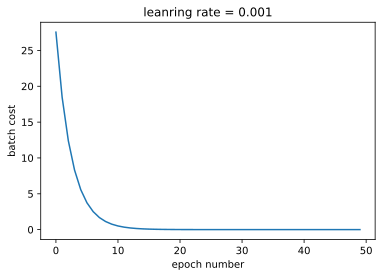

{'W': 
 [[ 1.9996946 -3.3999588]]
 <NDArray 1x2 @cpu(0)>, 'b': 
 [4.200172]
 <NDArray 1 @cpu(0)>}

In [89]:
model_scratch(batch_size, features, labels)

In [111]:
linear_regression = nn.Dense(1)
linear_regression.initialize()
for X, y in data_iter(batch_size, features, labels):
    A = linear_regression(X)
    print(A.shape)
    break


(10, 1)


In [145]:
def model_gluon(batch_size, features, labels, learning_rate=0.01, epoch_num=50):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
    l2_loss = gluon.loss.L2Loss()
    costs = []
    for epoch in range(epoch_num):
        train_loss = 0
        for X, y in data_iter(batch_size, features, labels):
            with autograd.record():
                A = net(X).reshape(1, -1)
                y = y.reshape(1, -1)
                loss = l2_loss(A, y)
            loss.backward()
            trainer.step(batch_size)
            train_loss += loss.mean().asscalar()
        train_loss /= (num_examples/batch_size)
        costs.append(train_loss)
        
        if epoch%5 == 0:
            print('after {0} epoch, cost is {1}'.format(epoch, train_loss))
            
    plt.plot(costs)
    plt.xlabel('epoch number')
    plt.ylabel('batch cost')
    plt.title('leanring rate = {0}'.format(learning_rate))
    plt.show()
    
    #print(net[0])
    return net

after 0 epoch, cost is 15.196260876655579
after 5 epoch, cost is 5.528691136837006
after 10 epoch, cost is 2.0138774907588957
after 15 epoch, cost is 0.7344521033763886
after 20 epoch, cost is 0.2681732887029648
after 25 epoch, cost is 0.09804596744477749
after 30 epoch, cost is 0.035903721572831275
after 35 epoch, cost is 0.01318050964269787
after 40 epoch, cost is 0.004862609438132495
after 45 epoch, cost is 0.0018149226868990809
after 50 epoch, cost is 0.0006971348708611913
after 55 epoch, cost is 0.0002868278200912755
after 60 epoch, cost is 0.0001360741847747704
after 65 epoch, cost is 8.05944937019376e-05
after 70 epoch, cost is 6.0180598084116354e-05
after 75 epoch, cost is 5.2671505254693326e-05
after 80 epoch, cost is 4.9904174557013906e-05
after 85 epoch, cost is 4.888372749519476e-05
after 90 epoch, cost is 4.8509790412936124e-05
after 95 epoch, cost is 4.837115519876534e-05


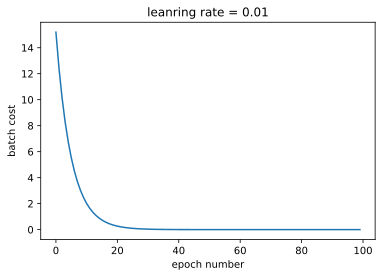

In [148]:
net = nn.Sequential()
net = model_gluon(batch_size, features, labels, epoch_num=100)

In [149]:
w = net[0].weight.data()
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = net[0].bias.data()
print('Error in estimating b', true_b - b)

Error in estimating w 
[[ 3.5500526e-04 -1.6689301e-05]]
<NDArray 1x2 @cpu(0)>
Error in estimating b 
[-0.00017214]
<NDArray 1 @cpu(0)>
